In [24]:
import pgmpy
import pyvis
import pandas as pd
from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch, TreeSearch
from pgmpy.estimators.CITests import chi_square
from pgmpy.estimators import K2Score, BDeuScore, BicScore
from pgmpy.utils import get_example_model
from pgmpy.sampling import BayesianModelSampling
import networkx as nx
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from iteration_utilities import duplicates
import numpy as np
from operator import itemgetter, attrgetter
from networkx.algorithms import tree, community
from networkx.generators.ego import ego_graph
import matplotlib.pylab as plt

In [27]:
# stanford dataset network site https://snap.stanford.edu/data

path_edges = "../data/github_users_network/musae_git_edges.csv"

path_target = "../data/github_users_network/musae_git_target.csv"


def reader(path_reader, path_target):
    df_edges = pd.read_csv(path_edges)
    df_target = pd.read_csv(path_target)
    return df_edges, df_target

def create_network_from_df(df):
    df = df.rename(columns={df.columns[0]: 'source', df.columns[1]: 'target'})
    Graphtype = nx.Graph()
    G = nx.from_pandas_edgelist(df,  create_using=Graphtype)
    return G
    #print(nx.info(G))
    #G.edges
    
    
def get_edge_list(G, sort=True):
    if sort:
        # sort by node 1
        sorted_edges = sorted(G.edges(), key=lambda x: x[0], reverse=True)
        return sorted_edges
    else:
        return list(G.edges())


def list_duplicate_edges(G):
    dup = list(duplicates(get_edge_list(G)))
    if len(dup) > 0:
        print(f"{len(dup)} duplicates found")
    return dup
    
def remove_nodes_with_low_degree(G, n):
    degree_sorted = sorted(G.degree(), key=lambda x: x[1], reverse=True)
    #keep top n nodes 
    node_list_remove = [node for node, v in degree_sorted[n::]]
    G.remove_nodes_from(node_list_remove)
    return G

def draw_network(G, edge_list=None, color='red'):
    # draw from existing nx object
    if edge_list is not None:
        G = nx.Graph()
        G.add_edges_from(edge_list)  # using a list of edge tuples
        # pruned network after Max weighted spanning tree algo
        pos = nx.spring_layout(G)
        nx.draw_networkx(G, pos=pos,node_color=color)
        print(nx.info(G))
        return G
    else:
        nx.draw_networkx(G, node_color=color)
        print(nx.info(G))
        return G

def max_spanning_tree(G, algorithm="kruskal"):
    mst = tree.maximum_spanning_edges(G, algorithm=algorithm, data=False)
    edgelist = list(mst)
    return edgelist
    
def compute_degree_betweeness(G):
    degree_dict = dict(G.degree(G.nodes()))
    betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality
    #eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality
    return degree_dict, betweenness_dict
    
    
def community_detection(G):
    communities = community.greedy_modularity_communities(G)
    modularity_dict = {} # Create a blank dictionary
    for i,c in enumerate(communities): # Loop through the list of communities, keeping track of the number for the community
        for name in c: # Loop through each person in a community
            modularity_dict[name] = i # Create an entry in the dictionary for the person, where the value is which group they belong to.

    return communities, modularity_dict
    
    
def set_attributes(G, **kwargs):
    for key in kwargs.keys(): 
        nx.set_node_attributes(G, kwargs[key],key)
    return G

    
def top_betweeness_nodes_with_attributes(G, top_n=20):
    betweenness_dict = nx.get_node_attributes(G,'betweeness')
    sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)
    #First get the top n nodes by betweenness as a list
    top_betweenness = sorted_betweenness[:top_n]
    degree_list = []
    modularity_list = []
    node_id = []
    betweenness_list = []
    #Then find and print their corresponding attributes: degree,  modularity
    for tb in top_betweenness: # Loop through top_betweenness
        degree = nx.get_node_attributes(G,'degree')[tb[0]] # Use degree_dict to access a node's degree
        modularity = nx.get_node_attributes(G,'modularity')[tb[0]]
        degree_list.append(degree)
        modularity_list.append(modularity)
        betweenness_list.append(tb[1])
        node_id.append(tb[0])
        #print("Name:", tb[0], "| Betweenness Centrality:", tb[1], "| Degree:", degree, "| Modularity", modularity)
    return pd.DataFrame({'id':node_id, 'betweeness': betweenness_list, 
                         'Degree': degree_list, 'Modularity': modularity_list})
        
def shortest_path(G, source_id, target_id):
    shortest_path = nx.shortest_path(G, source=source_id, target=target_id)
    print("Shortest path between user1 and user2:", shortest_path)
    return shortest_path

def plot_community_class_count(communities):
    count_list = []
    class_list = []
    for i,c in enumerate(communities):
        class_list.append(i)
        count_list.append(len(list(c)))

    df = pd.DataFrame({'class':class_list, 'count':count_list})
    df.plot.bar(x='class', y='count')
    return df

def connected_components(G, subgraph=False, node_list=None):
    # use nx.connected_components to get the list of components,
    # then use the max() command to find the largest one:
    components = nx.connected_components(G)
    print(components)
    largest_component = max(components, key=len)
    return components, largest_component

def plot_subgraph(G, node_list):
    subgraph = G.subgraph(node_list)
    diameter = nx.diameter(subgraph)
    print("Network diameter of largest component:", diameter)
    draw_network(subgraph, color='red')
    return subgraph

def plot_ego_network(G, n, radius):
    """
    plot ego network around a node n depending
    on radius setting i.e. only include upto
    n nodes directly or indirectly connected to
    this node
    """
    ego_nx = ego_graph(G, n, radius=radius)
    draw_network(ego_nx,color='red')
    return ego_nx
    
def export_graph(G, path='../data/github_network.gexf'):
    nx.write_gexf(G, path)

#### Read in dataset and plot graph after restriocting to top 1000  nodes with higest degree

The  lets prune this by running max weighted spanning tree algo

Name: 
Type: Graph
Number of nodes: 300
Number of edges: 5936
Average degree:  39.5733


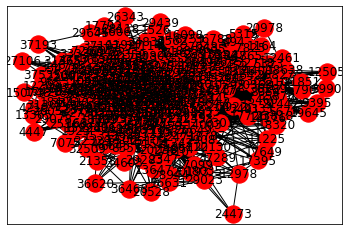

In [11]:

df_edges, df_target = reader(path_edges, path_target) 
main_nx = create_network_from_df(df_edges)
main_nx = remove_nodes_with_low_degree(main_nx, n=300)
main_nx = draw_network(main_nx, color='red')


#### Pruned network - Max Weighted Spanning tree

Name: 
Type: Graph
Number of nodes: 300
Number of edges: 299
Average degree:   1.9933


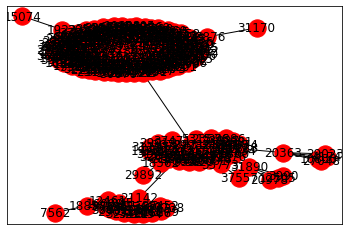

In [12]:
edge_list =  max_spanning_tree(main_nx, algorithm="kruskal")
prune_nx = draw_network(main_nx, edge_list=edge_list, color='red')

#### Compute metrics and list metrics for top betweeness centralty nodes

In [21]:
degree, betweenness = compute_degree_betweeness(prune_nx)

communities, modularity = community_detection(prune_nx)


metrics = {'degree': degree, 'betweeness': betweenness, 'modularity': modularity}
prune_nx = set_attributes(prune_nx, **metrics)
top_metrics = top_betweeness_nodes_with_attributes(prune_nx, top_n=10)
top_metrics


,id,betweeness,Degree,Modularity
0,27803,0.923571,215,0
1,29982,0.467868,52,1
2,21142,0.141950,22,2
3,20363,0.026621,5,3
4,31890,0.020000,4,4
5,18562,0.006689,2,1
6,35773,0.006689,2,1
7,18850,0.006689,2,2
8,18876,0.006689,2,5
9,1923,0.006689,2,6


Shortest path between user1 and user2: [29982, 18562]


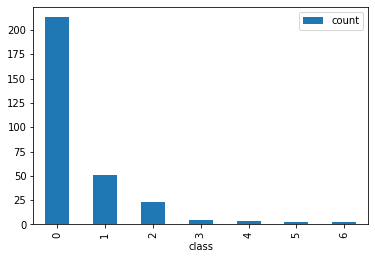

In [22]:

shortest = shortest_path(prune_nx, source_id=29982, target_id=18562)
community_count = plot_community_class_count(communities)

#### ego network and subgraph

<generator object connected_components at 0x7f863959f430>
Network diameter of largest component: 6
Name: 
Type: Graph
Number of nodes: 300
Number of edges: 299
Average degree:   1.9933


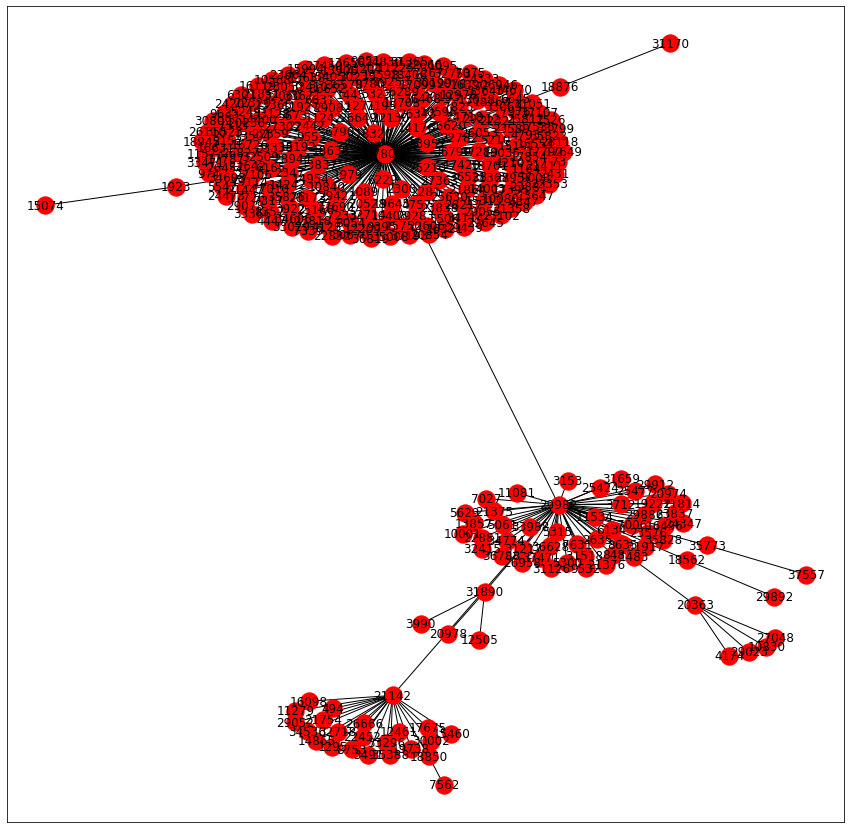

In [28]:
# this returns the entire graph as only one component in this graph 
plt.rcParams['figure.figsize'] = [15, 15]
#fig, ax = plt.subplots(1,2)
#ax
components, largest_component = connected_components(prune_nx)
subgraph = plot_subgraph(prune_nx, largest_component)


Name: 
Type: Graph
Number of nodes: 23
Number of edges: 22
Average degree:   1.9130


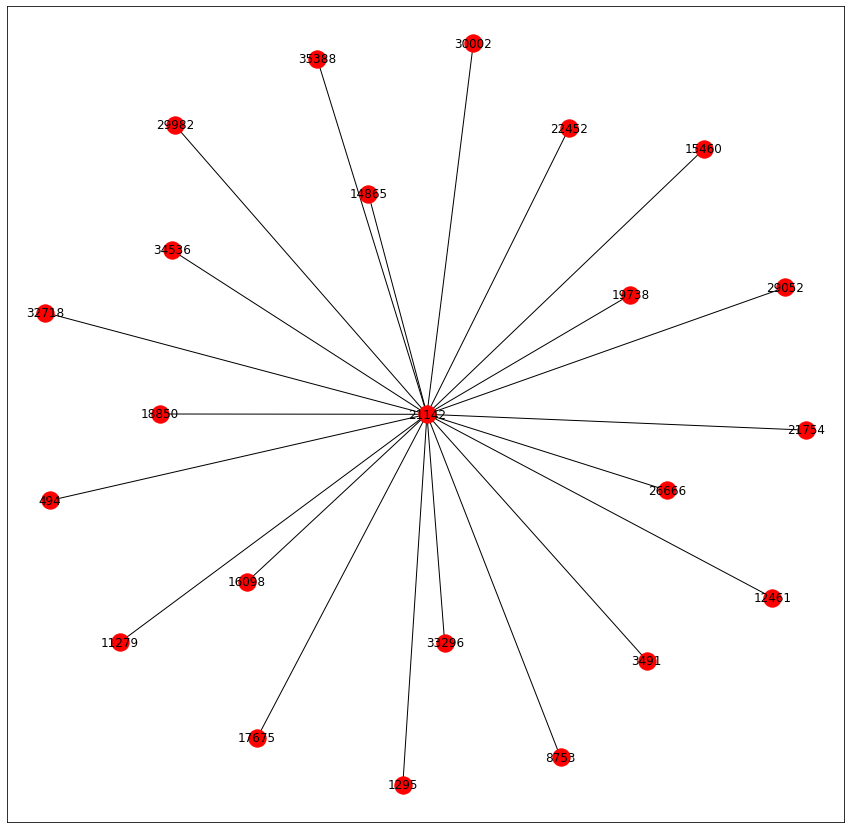

In [29]:
ego_nx = plot_ego_network(prune_nx, 21142, radius = 1)